In [1]:
# for installing faiss library
!wget  https://anaconda.org/pytorch/faiss-gpu/1.2.1/download/linux-64/faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!tar xvjf faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
!pip install mkl

--2020-05-22 01:36:03--  https://anaconda.org/pytorch/faiss-gpu/1.2.1/download/linux-64/faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
Resolving anaconda.org (anaconda.org)... 2606:4700::6811:5d18, 2606:4700::6811:5c18, 104.17.92.24, ...
Connecting to anaconda.org (anaconda.org)|2606:4700::6811:5d18|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5a15c9cc393ec612061f033a/5ac54beae586bb11ec0ace46?response-content-disposition=attachment%3B%20filename%3D%22faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20200521T200605Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjENb%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJHMEUCIFn923%2B1spK9lR%2BI2KGKYnMvEbpThyUk3j5cI6BdNx4OAiEAkor105ebmRLqb2IMEEpuo3M9IYGjgmoqApyKRWWGiD4qtAMILxAAGgw

In [2]:
!pip install mtcnn

  Using cached https://files.pythonhosted.org/packages/b4/8e/6565beb364587befbef5efad314e14f78be85d65c3709a4da09bd9dfbb65/mtcnn-0.1.0.tar.gz
    Complete output from command python setup.py egg_info:
    Python < 3.4.1 is not supported!
    
    ----------------------------------------
Command "python setup.py egg_info" failed with error code 1 in /tmp/pip-build-rtULzB/mtcnn/


In [3]:
import mtcnn

ModuleNotFoundError: No module named 'mtcnn'

In [0]:
import numpy as np
import cv2
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import os
import dlib

In [0]:
import faiss

In [0]:
detector = MTCNN()

In [0]:
#downloaded facenet_keras.h5 from https://drive.google.com/drive/folders/12aMYASGCKvDdkygSv1yQq8ns03AStDO_ 
facenet_model = load_model('/content/drive/My Drive/Colab Notebooks/face_recognition/models/facenet_keras.h5')

In [0]:
# path of the folder containing training images.
faces_folder_path = "/content/drive/My Drive/Colab Notebooks/face_recognition/faces/"

In [0]:
file_names = os.listdir(faces_folder_path)

In [0]:
images_paths = [ faces_folder_path + image for image in file_names]

In [0]:
len(images_paths)

31

In [0]:
# function that returns face encodings 
def get_face_encodings(path):
  # reading the image
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # detect faces using MTCNN detector
  faces = detector.detect_faces(img)
  if len(faces) == 0:
    print("there is no face in this picture")
  elif len(faces) > 1:
    print("please restrict to one face per image")
  # (x1, y1) top left corner of rectangle and (x2, y2) bottom right corner
  x1 = abs(faces[0]['box'][0])
  y1 = abs(faces[0]['box'][1])
  x2 = x1 + faces[0]['box'][2]
  y2 = y1 + faces[0]['box'][3]
  # extract/crop face from the whole image
  cropped_face = img[y1:y2, x1:x2]
  # resize the image
  cropped_face = Image.fromarray(cropped_face)
  cropped_face = cropped_face.resize((160, 160))
  cropped_face = np.asarray(cropped_face)
  cropped_face = cropped_face.astype('float32')
  # standardization
  mean, std = cropped_face.mean(), cropped_face.std()
  cropped_face = (cropped_face - mean) / std
  # transfer face into one sample (3 dimension to 4 dimension)
  sample = np.expand_dims(cropped_face, axis=0)
  # make prediction to get embedding
  encodings = facenet_model.predict(sample)
  return encodings[0]

In [0]:
face_encodings = []

In [0]:
for path in images_paths:
  encoding = get_face_encodings(path)
  face_encodings.append(encoding)

In [0]:
type(face_encodings[0][0])

numpy.float32

In [0]:
vectors = np.array(face_encodings)

In [0]:
dimension = 128     #dimension of feature vector of image 
no_of_vectors = 31  # number of training images(face encodings)
no_of_clusters = 3        #number of clusters

In [0]:
quantiser = faiss.IndexFlatL2(dimension)
index = faiss.IndexIVFFlat(quantiser, dimension, no_of_clusters, faiss.METRIC_L2)

In [0]:
index.train(vectors)   # index is trained and 3(no_of_clusters) clusters are created

In [0]:
index.add(vectors)     # all the feature vectors of the faces are added to the clusters created

In [0]:
index.nprobe = 2    # nprobe tells how many similar clusters to be visited during search(should be less than no. of clusters)  
n_query = 3         # no. of query images
k = 1           # return 1 nearest image

In [0]:
query_vectors = []

In [0]:
# inorder to get the correct valid faces.(we considered faces that are detected by this detector are valid)
face_detector = dlib.get_frontal_face_detector()

In [0]:
def detect_no_of_valid_faces(image_path):
  image = cv2.imread(image_path)
  detected_faces = face_detector(image, 1)
  return len(detected_faces)

In [0]:
#query image1 
q_image1 = "/content/drive/My Drive/Colab Notebooks/face_recognition/test/george.jpg"  # path of query image1
detected_faces = detect_no_of_valid_faces(q_image1)
if detected_faces != 1:
  print("INVALID!!!!!!!!!!")
else:
  query_vectors.append(get_face_encodings(q_image1))

In [0]:
#query image2
q_image2 = "/content/drive/My Drive/Colab Notebooks/face_recognition/test/indira.jpg"  # path of query image2
detected_faces = detect_no_of_valid_faces(q_image2)
if detected_faces != 1:
  print("INVALID!!!!!!!!!!")
else:
  query_vectors.append(get_face_encodings(q_image2))

In [0]:
#query image3
q_image3 = "/content/drive/My Drive/Colab Notebooks/face_recognition/test/img5.jpeg" # path of query image3
detected_faces = detect_no_of_valid_faces(q_image3)
if detected_faces != 1:
  print("INVALID!!!!!!!!!!")
else:
  query_vectors.append(get_face_encodings(q_image3))

In [0]:
query_vectors = np.array(query_vectors)

In [0]:
distances, indices = index.search(query_vectors, k)

In [0]:
distances

array([[177.64508 ],
       [120.608246],
       [ 78.177124]], dtype=float32)

In [0]:
indices       # displays 3 nearest neighbor indices of the 3 query images if all of them are valid

array([[ 0],
       [22],
       [14]])

In [0]:
# to display the query image along with recognised face name.
def show_image(image_path, name):
  print(image_path)
  image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  faces = detector.detect_faces(image);
  print(faces)
  x1 = abs(faces[0]['box'][0])
  y1 = abs(faces[0]['box'][1])
  x2 = x1 + faces[0]['box'][2]
  y2 = y1 + faces[0]['box'][3]
  cv2.rectangle(image, (x1,y1) ,(x2, y2), (0,0,255), 2)
  cv2.putText(image, name, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX ,  0.7, (255,215, 0), 1, cv2.LINE_AA) 
  #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  imgplot = plt.imshow(image)

In [0]:
# calculates euclidean distance between the query vector and the its detected nearest neighbor 
def euclid_distance(i):
  return np.linalg.norm(vectors[indices[i][0]] - query_vectors[i], axis=0)

/content/drive/My Drive/Colab Notebooks/face_recognition/test/george.jpg
[{'box': [61, 40, 83, 113], 'confidence': 0.999961256980896, 'keypoints': {'left_eye': (85, 86), 'right_eye': (122, 82), 'nose': (105, 107), 'mouth_left': (89, 125), 'mouth_right': (126, 121)}}]


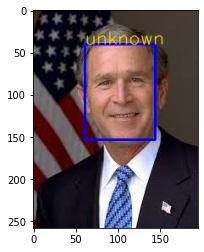

In [0]:
# query image1
dist1 = euclid_distance(0)
if dist1 < 10:
  name1 = file_names[indices[0][0]]
else:
  name1 = "unknown"
show_image(q_image1, name1)

/content/drive/My Drive/Colab Notebooks/face_recognition/test/indira.jpg
[{'box': [102, 51, 76, 105], 'confidence': 0.9999994039535522, 'keypoints': {'left_eye': (125, 95), 'right_eye': (159, 99), 'nose': (139, 122), 'mouth_left': (122, 131), 'mouth_right': (155, 135)}}]


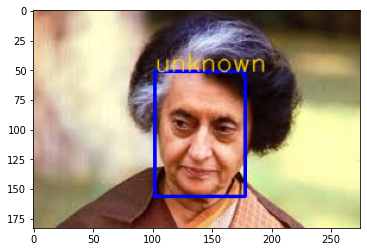

In [0]:
#query image2
dist2 = euclid_distance(1)
if dist2 < 10:
  name2 = file_names[indices[1][0]]
else:
  name2 = "unknown"
show_image(q_image2, name2)

/content/drive/My Drive/Colab Notebooks/face_recognition/test/img5.jpeg
[{'box': [95, 55, 83, 100], 'confidence': 0.9999394416809082, 'keypoints': {'left_eye': (107, 94), 'right_eye': (140, 86), 'nose': (118, 107), 'mouth_left': (117, 133), 'mouth_right': (147, 126)}}]


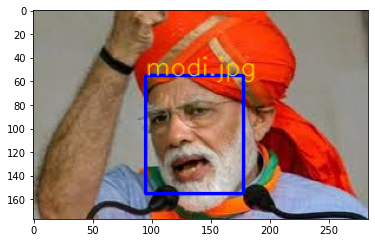

In [0]:
#query image3
dist3 = euclid_distance(2)
if dist3 < 10:
  name3 = file_names[indices[2][0]]
else:
  name3 = "unknown"
show_image(q_image3, name3)